# 데이터 전처리

@author 컴퓨터과학과 황승현
KoGes 데이터 전처리

2023-05-29 수정... 데이터 쳐내기

전처리 절차

1. 데이터셋 분리
    - ~~남성~~ 사용 안 함
    - 여성(폐경 전) < AS1_PMYN_C: 1
    - 여성(폐경 후) < AS1_PMYN_C: 2
2. 각각 사용할 독립변수, 종속변수 행 추출
3. 질환유무, 약물력 변수 가공
4. 가족력, 가족과의 관계 변수 가공
    - 부, 모, 형제자매, 기타 -> 부모, 형제자매, 기타, 해당없음
5. 종속변수 AS1_OP 가공
    - AS1_DT
    - AS1_MT
6. 데이터셋을 DataFrame으로 불러오고 독립변수는 4가지로 분류 (binary, cath0, cath1, cnt, tumor_name)
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  -  catH0: 계층 없는 범주형(>03) 변수, 벡터화(one-hot-encoding)
  -  catH1: 계층 있는 범주형 변수, 표준화
  -    cnt: 연속형 변수, 정규화, 표준화
  - tumor_name
7. 결측값 제거 : 일단 0으로 대치
8. 연속형 변수 스케일링
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수
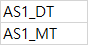

## 준비

- 라이브러리 불러오기
- 데이터셋, 사용할 변수 불러오기

In [2]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [3]:
# 데이터셋 불러오기
# dataset = pd.read_csv("dataset/Dataset_OP_230316_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230330_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230417_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230424_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
dataset = pd.read_csv("dataset/Dataset_OP_230614_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' '])
dataset.head

C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\842177691.py:6: DtypeWarning: Columns (7,9,156,299) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("dataset/Dataset_OP_230614_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' '])


<bound method NDFrame.head of                AS1_SEX  AS1_AGE  AS1_FAMNUM  AS1_HAND  AS1_SEAS  AS1_MARRYA   
DIST_ID                                                                       
NIH2307795046        1       53         4.0       1.0       3.0         2.0  \
NIH2307713334        2       44         2.0       1.0       2.0         2.0   
NIH2307455306        2       43         6.0       1.0       2.0         2.0   
NIH2307778268        1       61         4.0       1.0       4.0         2.0   
NIH2307137554        2       64         4.0       1.0       1.0         2.0   
...                ...      ...         ...       ...       ...         ...   
NIH2307591031        2       60         3.0       1.0       3.0         2.0   
NIH2307808901        2       62         4.0       1.0       1.0         2.0   
NIH2307930134        2       65         2.0       1.0       3.0         3.0   
NIH2307023172        2       69         5.0       1.0       1.0         3.0   
NIH2307534318        2

In [4]:
# 특성별로 분류
# var_to_use = pd.read_csv("dataset/var_to_use_2023-03-30T2240I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-21T1258I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-24T1830I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-28T1610I.csv")
var_to_use = pd.read_csv("dataset/var_to_use_2023-06-13T1650I.csv")
var_to_use


,binary,cath0,cath1,cnt,dependent
0,AS1_SEX,AS1_EDUA,AS1_INCOME,AS1_AGE,AS1_DT
1,AS1_HT,AS1_DRINK,AS1_PHYSTB,AS1_TOTALC,AS1_MT
2,AS1_DM,AS1_SMOKEA,AS1_PHYSIT,AS1_PMAG_C,NaN
3,AS1_AL,AS1_FMOSREL_N,AS1_PHYACTL,AS1_MNSAG,NaN
4,AS1_MI,AS1_FMOSREL_O,AS1_PHYACTM,AS1_CHILD_P,NaN
...,...,...,...,...,...
70,NaN,NaN,NaN,AS1_BPSIT1RS,NaN
71,NaN,NaN,NaN,AS1_BPSIT1SYS,NaN
72,NaN,NaN,NaN,AS1_BPSIT1LD,NaN
73,NaN,NaN,NaN,AS1_BPSIT1RD,NaN


## 데이터 가공

- 기존 데이터로 새로운 데이터 만들기
- if 문 쓰면 안됨!
    - The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
- np.where 사용할 것!

### 종속변수 결측값 drop

In [5]:
# 종속변수의 결측값이 있으면 drop
dataset.dropna(subset=['AS1_DT', 'AS1_MT'], inplace=True)

# 남성(1) drop, 여성(2)만 가져옴
dataset = dataset[dataset['AS1_SEX'] == 2]

# 새로운 종속변수 만들기 OP: 골다공증 여부
dataset['OP'] = np.where((dataset['AS1_DT'] <= -2.5) | (dataset['AS1_MT'] <= -2.5), 1, 0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4680 entries, NIH2307713334 to NIH2307534318
Columns: 839 entries, AS1_SEX to OP
dtypes: float64(795), int32(1), int64(38), object(5)
memory usage: 30.0+ MB


C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\1920078704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['OP'] = np.where((dataset['AS1_DT'] <= -2.5) | (dataset['AS1_MT'] <= -2.5), 1, 0)


### 각종 질환 가공

- 질환 유무
    - 각종 종양 유무 (AS1_TOTCA1)
- 약물력
- 가족력

In [6]:
# 질환유무 가공
disease_list = np.array(['HT', 'DM', 'AL', 'MI', 'TH', # 질환 목록
                         'CH', 'CD', 'LP', 'AS', 'CL',
                         'KD', 'CV', 'GT' ]) # UL, PV, HN, TOTCA1 제외

dataset['AS1_ARRM'] = np.where((dataset['AS1_JOAR'] == 2) | (dataset['AS1_JORM'] == 2) | (dataset['AS1_TRTAR'] == 2), 1, 0) # 관절혐은 조건 3가지 만족하면 1 아니면 0

for x in disease_list:
    dataset['AS1_'+x] = np.where((dataset['AS1_PD'+x] == 2) | (dataset['AS1_TRT'+x] == 2), 1, 0) # 질환여부 정의. AS1_PDㅇㅇ 또는 AS1_TRTㅇㅇ 이 2이면 1 아니면 0


C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\376098338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_ARRM'] = np.where((dataset['AS1_JOAR'] == 2) | (dataset['AS1_JORM'] == 2) | (dataset['AS1_TRTAR'] == 2), 1, 0) # 관절혐은 조건 3가지 만족하면 1 아니면 0
C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\376098338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_'+x] = np.where((dataset['AS1_PD'+x] == 2) | (dataset['AS1_TRT'+x] == 2), 1, 0) # 질환여부 정의. AS1_PDㅇㅇ 또는 AS1_TRTㅇㅇ 이 2이면 1 아니면 0

In [7]:
# 약물력 가공
drug_list = np.array(['ST', 'CP', 'INS', 'HT', 'AR', 
                      'TH', 'FH', 'OS', 'STK', 'AS',
                      'LP', 'SP', 'SL'])  # UL, DM, CP, HP 제외 SP, SL 추가
for x in drug_list:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)


C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\1121918423.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)
C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\1121918423.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)
C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\1121918423.py:6: SettingWithCopyW

In [8]:
# 와 ChatGPT가 아니었다면 np.all과 np.any를 몰랐을거야!
# 가족력 가공
# N: 가족력 없음, P: parent 부모, S: sibling 형제자매, O: other 기타
# N: REL1A~4A까지 99999
# P: REL1A~4A중 1, 2 있을 때
# S: REL1A~4A중 3 있을 때
# O: REL1A~4A중 4 있을 때

# disease_dict = {
#     'HT': 4, 'DM': 4, 'CVA': 3, 'HE': 2, 'OS': 2,
#     'CVB': 2, 'CD': 2, 'PV': 2, 'LP': 2, 'GT': 2,'CH': 1
# }
disease_dict = { 'OS': 2 }

for disease, num_family in disease_dict.items():
    dataset[f'AS1_FM{disease}REL_N'] = np.all(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 99999, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_P'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] <= 2, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_S'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 3, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_O'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 4, axis=1).astype(int)

C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\1486024573.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'AS1_FM{disease}REL_N'] = np.all(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 99999, axis=1).astype(int)
C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\1486024573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'AS1_FM{disease}REL_P'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] <= 2, axis=1).astype(int)
C:\Users

In [9]:
dataset[[f'AS1_FM{disease}REL_{family}' for disease in disease_dict.keys() for family in ['N', 'P', 'S', 'O']]]

,AS1_FMOSREL_N,AS1_FMOSREL_P,AS1_FMOSREL_S,AS1_FMOSREL_O
DIST_ID,,,,
NIH2307713334,0,0,0,0
NIH2307455306,0,0,0,0
NIH2307137554,0,0,0,0
NIH2307649667,0,0,0,0
NIH2307899915,0,1,0,0
...,...,...,...,...
NIH2307591031,0,0,0,0
NIH2307808901,0,0,0,0
NIH2307930134,0,0,0,0


### 여성력 가공

- ~~질환~~
- 약물
- 기타 수술 (AS1_OBGYOP)
    - 자궁경부암수술/ 자궁암수술/ 자궁내막암/자궁경부암,나팔관제거수술/ 만 1 나머지는 0

In [10]:
# 여성력 가공
# 남성 데이터 셋을 제거하여 필요없음

# 남자일 경우: 0 여자일 경우: 그대로
# for x in ['CP', 'FH']:
#     dataset['AS1_DR'+x] = np.where(dataset['AS1_SEX'] == '1',
#                                    0,
#                                    np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 2, 1))

for x in ['CP', 'FH']:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)

    
# women = np.array(['AS1_PREG', 'AS1_HYST', 'AS1_HYSTOVARYW', 'AS1_OVARYW',
#                   'AS1_OBGYOP', 'AS1_BRCA', 'AS1_DRCP', 'AS1_DRFH'])
#
# for x in women:
#     dataset[x] = np.where((dataset['AS1_SEX'] == 1), 0, dataset[x])

C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\3218887834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)


### 앉은 자세 혈압
- AS1_BPSit1SYS
    - AS1_BPSit1LS, AS1_BPSit1RS 변수 중 높은 값
- AS1_BPSit1DIA
    - AS1_BPSit1LD,  AS1_BPSit1RD  변수 중 높은 값

In [11]:
dataset['AS1_BPSIT1SYS'] = np.where(dataset['AS1_BPSIT1LS'] > dataset['AS1_BPSIT1RS'], dataset['AS1_BPSIT1LS'], dataset['AS1_BPSIT1RS'])

dataset['AS1_BPSIT1DIA'] = np.where(dataset['AS1_BPSIT1LD'] > dataset['AS1_BPSIT1RD'], dataset['AS1_BPSIT1LD'], dataset['AS1_BPSIT1RD'])

C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\2122532319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_BPSIT1SYS'] = np.where(dataset['AS1_BPSIT1LS'] > dataset['AS1_BPSIT1RS'], dataset['AS1_BPSIT1LS'], dataset['AS1_BPSIT1RS'])
C:\Users\sh22h\AppData\Local\Temp\ipykernel_6868\2122532319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_BPSIT1DIA'] = np.where(dataset['AS1_BPSIT1LD'] > dataset['AS1_BPSIT1RD'], dataset['AS1_BPSIT1LD'], dataset['AS1_BPSIT1RD'])


### 타입 별 분리

In [12]:
# var_to_use의 각 열 가져옴

raw_binary = dataset.reindex(columns=(var_to_use['binary'].dropna()))
raw_cath0 = dataset.reindex(columns=(var_to_use['cath0'].dropna()))
raw_cath1 = dataset.reindex(columns=(var_to_use['cath1'].dropna()))
raw_cnt = dataset.reindex(columns=(var_to_use['cnt'].dropna()))
raw_label = dataset.reindex(columns=(var_to_use['dependent'].dropna()))

In [13]:
# null인 행이 있다.... 코드북과 데이터셋이 불일치한다.
target = raw_cnt
null_cell = pd.Series(index=target.columns)
null_cell = null_cell[target.isnull().sum() >= len(dataset)]  # 코드북에 없는 데이터 리스트
null_cell

Series([], dtype: float64)

In [14]:
raw_label

dependent,AS1_DT,AS1_MT
DIST_ID,,
NIH2307713334,-0.4,0.4
NIH2307455306,0.0,-1.0
NIH2307137554,-1.8,-1.9
NIH2307649667,-2.0,-1.7
NIH2307899915,0.1,-0.1
...,...,...
NIH2307591031,-3.0,0.2
NIH2307808901,-3.3,-4.1
NIH2307930134,-3.9,-2.4


### 결측값 대치 (문제 있음)
- 일부 데이터의 많은 결측값
  - 77777 -> 0
    - AS1_TOTALC
    - AS1_HVSMAM
  - 99999 -> ?
    - AS1_FMOSREL1A
    - AS1_CA_U
    - AS1_NA_U
    - AS1_K_U

  - 변수 정리할 때까지, 그냥 0으로 대체

In [15]:
# 원 데이터의 결측값 모두 0으로 대치
raw_binary = raw_binary.fillna(0)
raw_cath0 = raw_cath0.fillna(0)
raw_cath1 = raw_cath1.fillna(0)
raw_cnt = raw_cnt.fillna(0)

raw_label = raw_label.fillna(0)

### 데이터 균일 분포에 매핑

- QuantileTransformer
> QuantileTransformer provides a non-parametric transformation to map the data to a uniform distribution with values between 0 and 1

In [16]:
quantile_transformer = QuantileTransformer(random_state=0)

In [17]:
binary = pd.DataFrame(quantile_transformer.fit_transform(raw_binary), index=dataset.index, columns=raw_binary.columns).astype('float')
cath1 = pd.DataFrame(quantile_transformer.fit_transform(raw_cath1), index=dataset.index, columns=raw_cath1.columns).astype('float')
cnt = pd.DataFrame(quantile_transformer.fit_transform(raw_cnt), index=dataset.index, columns=raw_cnt.columns).astype('float')

cath0 = pd.get_dummies(raw_cath0, columns=raw_cath0.columns, drop_first=True, dtype='float64') # one-hot-encoding

label = pd.DataFrame(quantile_transformer.fit_transform(raw_label), index=dataset.index, columns=raw_label.columns).astype('float')

## 데이터셋 분리 및 csv로 변환

- ~~남성~~ 사용 안 함
- 여성(폐경 전) < AS1_PMYN_C: 1
    - X_premeno_woman
    - y_premeno_woman
- 여성(폐경 후) < AS1_PMYN_C: 2
    - X_postmeno_woman
    - y_postmeno_woman

In [18]:
X = pd.concat([binary, cath0, cath1, cnt], axis=1)
y = dataset['OP']

post_processing = pd.concat([X, y])

In [19]:
post_processing

,AS1_SEX,AS1_HT,AS1_DM,AS1_AL,AS1_MI,AS1_TH,AS1_CH,AS1_CD,AS1_LP,AS1_AS,...,AS1_BMI,AS1_BDFTR,AS1_BDCMSC,AS1_BPSIT1LS,AS1_BPSIT1RS,AS1_BPSIT1SYS,AS1_BPSIT1LD,AS1_BPSIT1RD,AS1_BPSIT1DIA,0
DIST_ID,,,,,,,,,,,,,,,,,,,,,
NIH2307713334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.520397,0.747247,0.318819,0.139139,0.125125,0.086587,0.251752,0.045045,0.172172,NaN
NIH2307455306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.704259,0.664164,0.842342,0.543043,0.467968,0.469970,0.565065,0.459960,0.479479,NaN
NIH2307137554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.125125,0.392392,0.071071,0.978979,0.987988,0.984484,0.946446,0.967467,0.952953,NaN
NIH2307649667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.879889,0.775776,0.733233,0.543043,0.628128,0.583083,0.565065,0.632633,0.565566,NaN
NIH2307899915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.295398,0.200701,0.625626,0.180681,0.125125,0.117618,0.251752,0.371872,0.304304,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIH2307591031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
NIH2307808901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
NIH2307930134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [20]:
y.value_counts()

OP
0    3785
1     895
Name: count, dtype: int64

In [21]:
X.to_csv("dataset/scaled/X_230330.csv")
y.to_csv("dataset/scaled/y_230330.csv")

In [21]:

meno1 = dataset['AS1_PMYN_C'] == 1
meno2 = dataset['AS1_PMYN_C'] == 2

X_premeno_woman = X.loc[meno1]
X_postmeno_woman = X.loc[meno2]
y_premeno_woman = y.loc[meno1]
y_postmeno_woman = y.loc[meno2]
print(f"폐경 전 여성의 골다공증:\n {y_premeno_woman.value_counts()}"
      f"\n\n폐경 후 여성의 골다공증:\n {y_postmeno_woman.value_counts()}")

폐경 전 여성의 골다공증:
 OP
0    1651
1      67
Name: count, dtype: int64

폐경 후 여성의 골다공증:
 OP
0    2109
1     825
Name: count, dtype: int64


In [22]:
X_premeno_woman.to_csv('./dataset/scaled/X_premeno_20230614.csv')
X_postmeno_woman.to_csv('./dataset/scaled/X_postmeno_20230614.csv')
y_premeno_woman.to_csv('./dataset/scaled/y_premeno_20230614.csv')
y_postmeno_woman.to_csv('./dataset/scaled/y_postmeno_20230614.csv')

In [23]:
y_premeno_woman

DIST_ID
NIH2307713334    0
NIH2307455306    0
NIH2307635434    0
NIH2307563051    0
NIH2307534459    0
                ..
NIH2307492442    0
NIH2307287708    0
NIH2307394231    0
NIH2307665690    0
NIH2307625463    0
Name: OP, Length: 1718, dtype: int32

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_premeno_woman, y_premeno_woman, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_train

(1374, 139) (344, 139) (1374,) (344,)


DIST_ID
NIH2307821337    0
NIH2307568629    0
NIH2307006575    0
NIH2307025885    0
NIH2307202124    0
                ..
NIH2307183531    0
NIH2307161658    0
NIH2307489492    0
NIH2307962564    0
NIH2307365914    0
Name: OP, Length: 1374, dtype: int32

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_postmeno_woman, y_postmeno_woman, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_train

(2347, 139) (587, 139) (2347,) (587,)


DIST_ID
NIH2307808754    0
NIH2307618867    0
NIH2307144156    1
NIH2307449183    0
NIH2307081068    0
                ..
NIH2307893627    1
NIH2307002244    1
NIH2307413889    0
NIH2307534866    0
NIH2307325698    0
Name: OP, Length: 2347, dtype: int32